# Traing the Transformer on the Gissinger system

In [1]:
%load_ext autoreload
%autoreload 2


import sys
import logging
import torch
from trphysx.config import HfArgumentParser
from trphysx.config.args import ModelArguments, TrainingArguments, DataArguments, ArgUtils
from trphysx.config import AutoPhysConfig
from trphysx.transformer import PhysformerTrain, PhysformerGPT2
from trphysx.embedding import AutoEmbeddingModel
from trphysx.viz import AutoViz
from trphysx.data_utils import AutoDataset
from trphysx.utils.trainer import Trainer

logger = logging.getLogger(__name__)

## Setting parameters

In [2]:
emb_dir = "./results/gissinger_results/embedding_gissinger/ntrain2048_epochs200_batch512/checkpoints/"
    
data_dir  = "../data/gissinger/"
epochs = "300"
argv = []
argv = argv + ["--init_name", "gissinger"]
argv = argv + ["--embedding_file_or_path", emb_dir+"embedding_gissinger200.pth"]
argv = argv + ["--training_h5_file",data_dir + "gissinger_training_rk.hdf5"]
argv = argv + ["--eval_h5_file",data_dir + "gissinger_valid_rk.hdf5"]
argv = argv + ["--train_batch_size", "32"]
argv = argv + ["--stride", "64"]
argv = argv + ["--n_train", "2048"]
argv = argv + ["--save_steps", "25"]
argv = argv + ["--n_eval", "16"]
argv = argv + ["--epochs",epochs]

### Parsing arguments, setting up logger and configurations

In [3]:
# Parse arguments using the hugging face argument parser
parser = HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
model_args, data_args, training_args = parser.parse_args_into_dataclasses(argv)

# Setup logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO if training_args.local_rank in [-1, 0] else logging.WARN)
# Configure arguments after intialization 
model_args, data_args, training_args = ArgUtils.config(model_args, data_args, training_args)

# Load model configuration
config = AutoPhysConfig.load_config(model_args.config_name)

01/16/2023 18:49:26 - INFO - root -   Using a single GPU for training.


## Initializing model

In [4]:
# Load embedding model
embedding_model = AutoEmbeddingModel.load_model(
    model_args.embedding_name, 
    config, 
    model_args.embedding_file_or_path).to(training_args.src_device)

# Load visualization utility class
viz = AutoViz.load_viz(model_args.viz_name, plot_dir=training_args.plot_dir)

# Init transformer model
transformer = PhysformerGPT2(config, model_args.model_name)
model  = PhysformerTrain(config, transformer)
if(training_args.epoch_start > 0):
    model.load_model(training_args.ckpt_dir, epoch=training_args.epoch_start)
if(model_args.transformer_file_or_path):
    model.load_model(model_args.transformer_file_or_path)


01/16/2023 18:49:26 - INFO - trphysx.embedding.embedding_gissinger -   Number of embedding parameters: 36192
01/16/2023 18:49:26 - INFO - trphysx.embedding.embedding_model -   Loading embedding model from file: ./results/gissinger_results/embedding_gissinger/ntrain2048_epochs200_batch512/checkpoints/embedding_gissinger200.pth
01/16/2023 18:49:28 - INFO - trphysx.transformer.phys_transformer_gpt2 -   Number of parameters: 53984


## Defining train and validation datasets

In [5]:
# Initialize training and validation datasets
training_data = AutoDataset.create_dataset(
      model_args.model_name,
      embedding_model, 
      data_args.training_h5_file, 
      block_size=config.n_ctx, 
      stride=data_args.stride,
      ndata=data_args.n_train, 
      overwrite_cache=data_args.overwrite_cache)

eval_data = AutoDataset.create_dataset(
      model_args.model_name,
      embedding_model, 
      data_args.eval_h5_file, 
      block_size=256,
      stride=1024,
      ndata=data_args.n_eval, 
      eval = True,
      overwrite_cache=data_args.overwrite_cache)

01/16/2023 18:49:28 - INFO - trphysx.data_utils.dataset_phys -   Creating features from dataset file at ../data/gissinger
/home/mirksonius/Desktop/seminar_fizika/kod/trphysx/data_utils/dataset_gissinger.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  data_series = torch.Tensor(h5_file[key]).to(embedder.devices[0]).view([-1] + embedder.input_dims)
01/16/2023 18:49:37 - INFO - trphysx.data_utils.dataset_gissinger -   Collected 2048 time-series from hdf5 file. Total of 14336 time-series.
01/16/2023 18:49:39 - INFO - trphysx.data_utils.dataset_phys -   Saving features into cached file ../data/gissinger/cached2048_GissingerEmbedding_64_gissinger_training_rk.hdf5 [took 2.608 s]
01/16/2023 18:49:39 - INFO - trphysx.data_utils.dataset_phys -   Creating features from dataset file

## Optimizer initialization

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=training_args.lr, weight_decay=1e-10)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 14, 2, eta_min=1e-9)

## Defining trainer and training

In [7]:
trainer = Trainer(
        model, 
        training_args, 
        (optimizer, scheduler), 
        train_dataset = training_data, 
        eval_dataset = eval_data, 
        embedding_model = embedding_model,
        viz=viz)
    
trainer.train()

01/16/2023 18:49:52 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00095
01/16/2023 18:49:52 - INFO - trphysx.utils.trainer -   Epoch 1: Training loss 0.03823
01/16/2023 18:49:52 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00095
01/16/2023 18:49:52 - INFO - trphysx.utils.trainer -   Evaluating...
01/16/2023 18:49:58 - INFO - trphysx.utils.trainer -   Eval embedding error: 0.52, State error: 1.06
01/16/2023 18:49:58 - INFO - trphysx.utils.trainer -   Checkpointing model, optimizer and scheduler.
01/16/2023 18:50:10 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00089
01/16/2023 18:50:10 - INFO - trphysx.utils.trainer -   Epoch 2: Training loss 0.00026
01/16/2023 18:50:21 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00081
01/16/2023 18:50:21 - INFO - trphysx.utils.trainer -   Epoch 3: Training loss 0.00016
01/16/2023 18:50:33 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00072
01/16/2023 18:50:33 - INFO - trphysx.util

# Vizualization

Validation prediction for epoch: 1


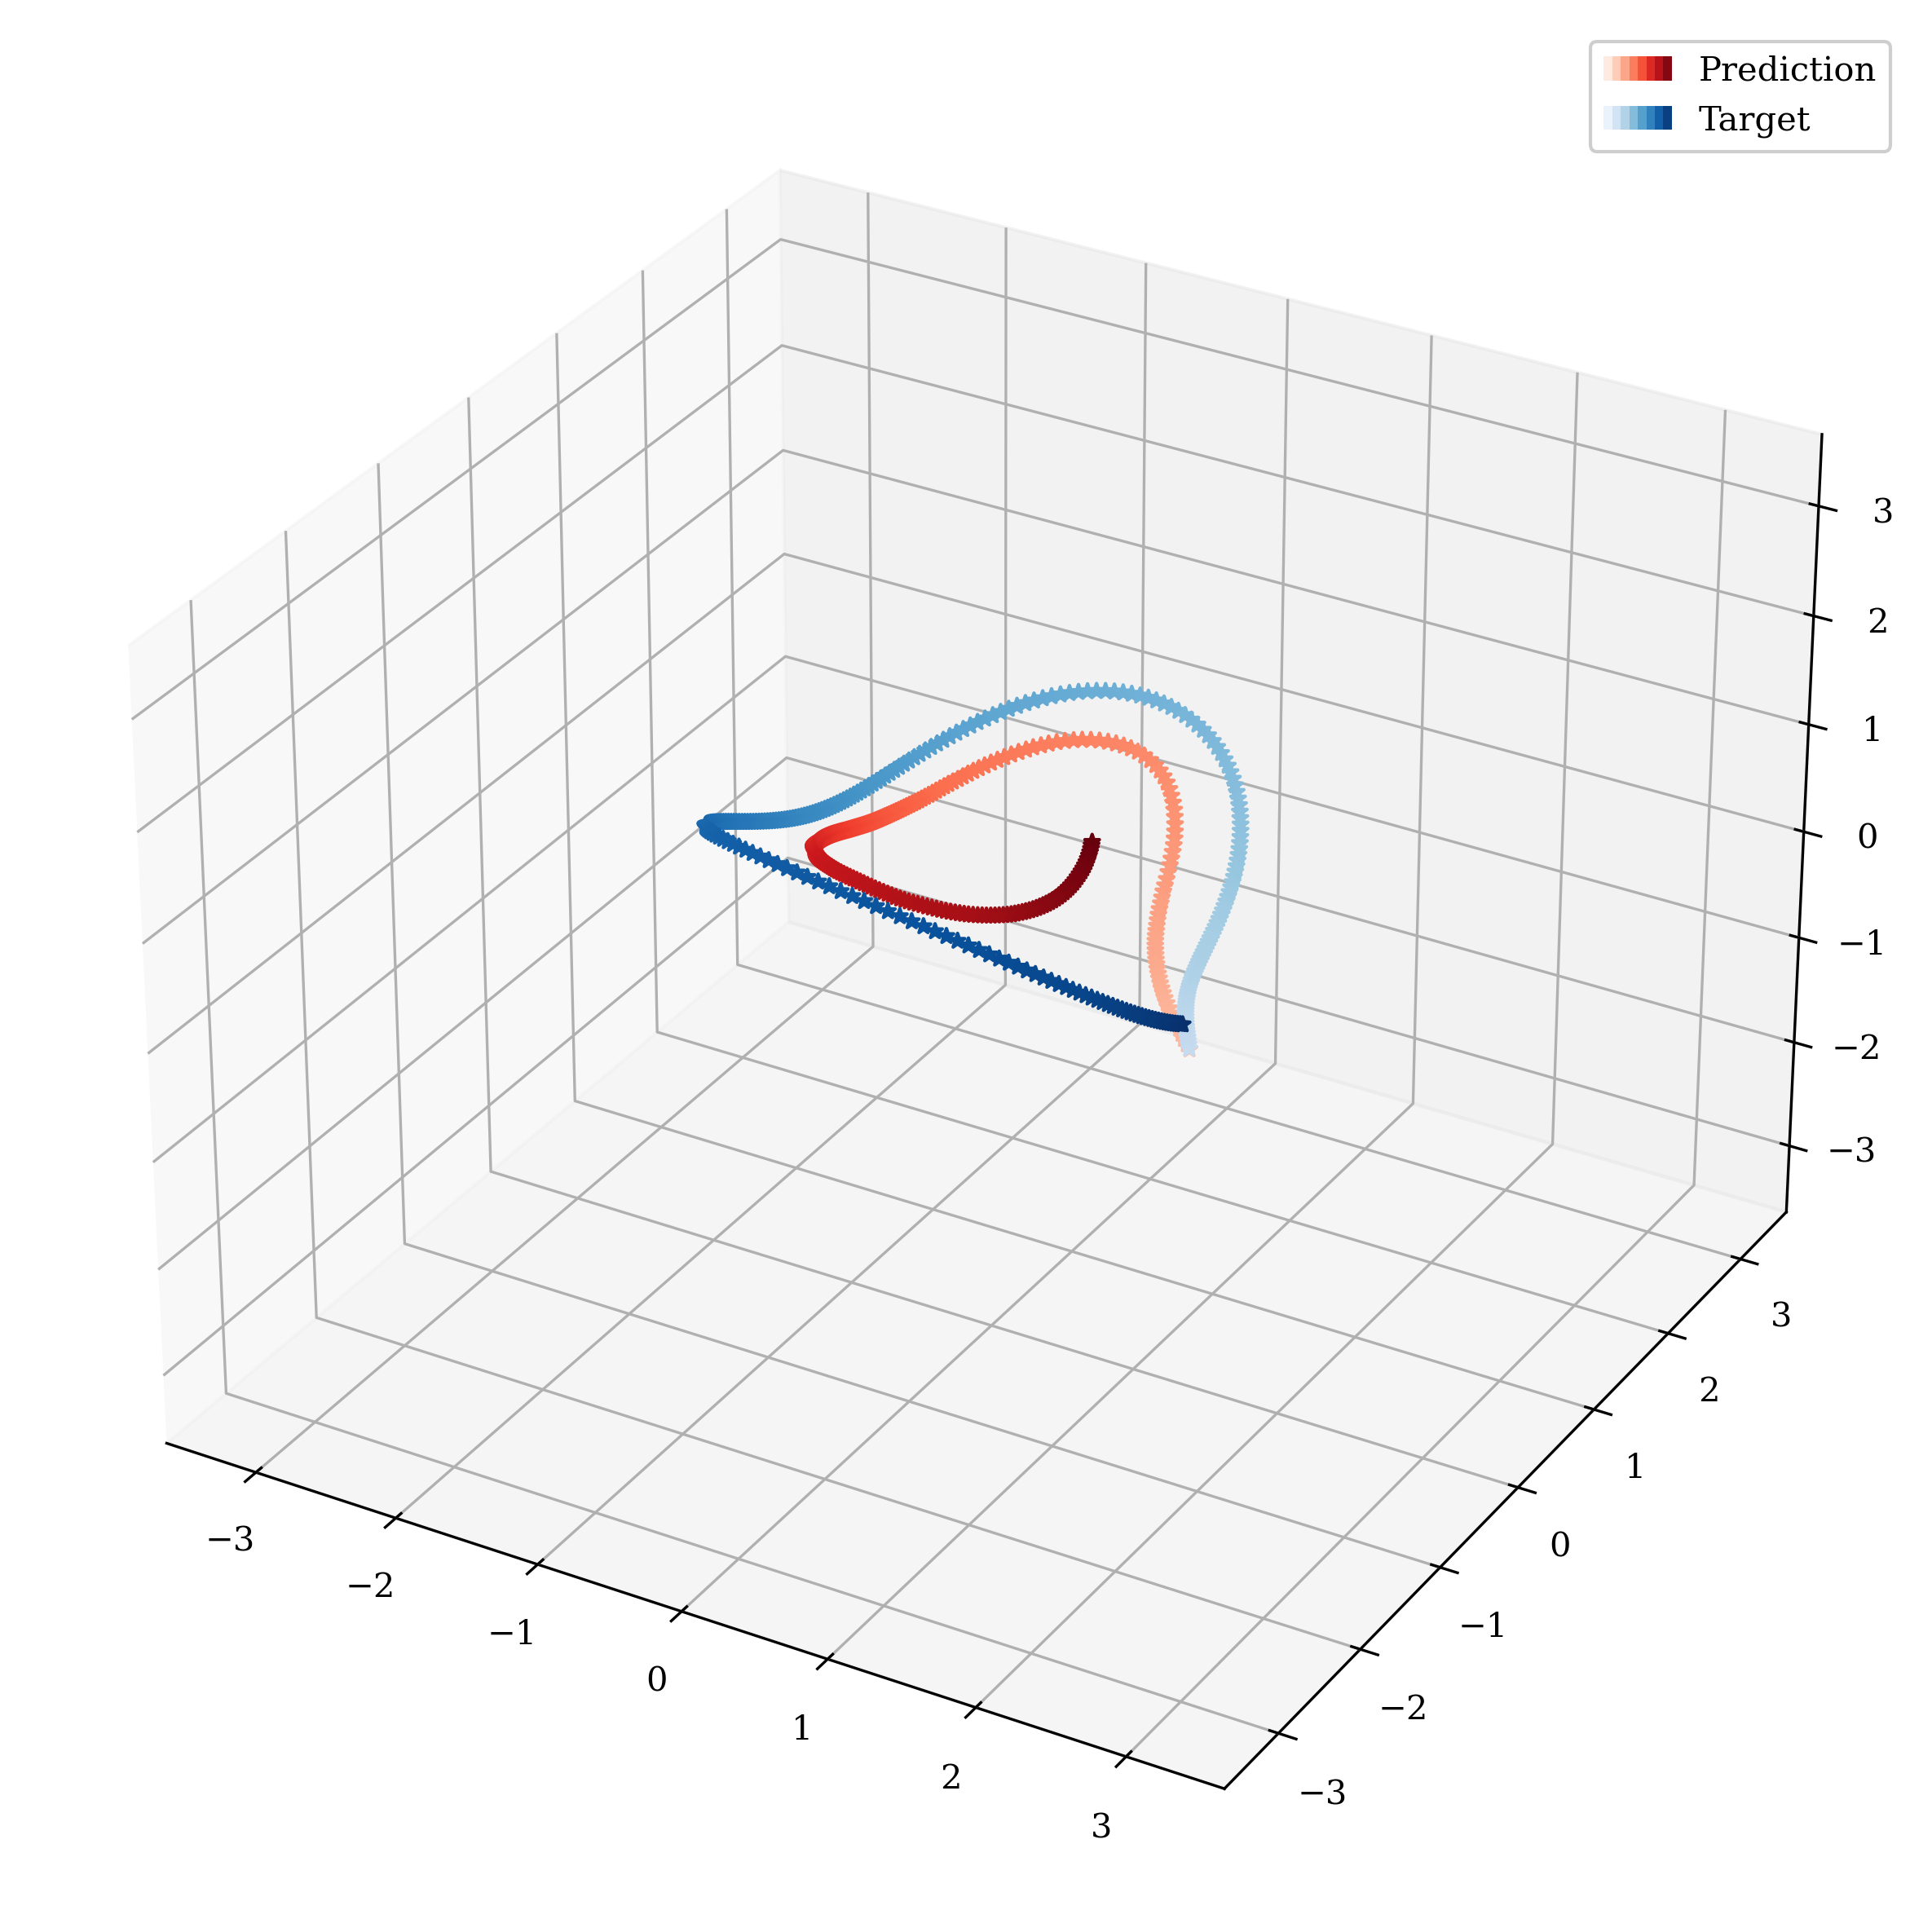

Validation prediction for epoch: 50


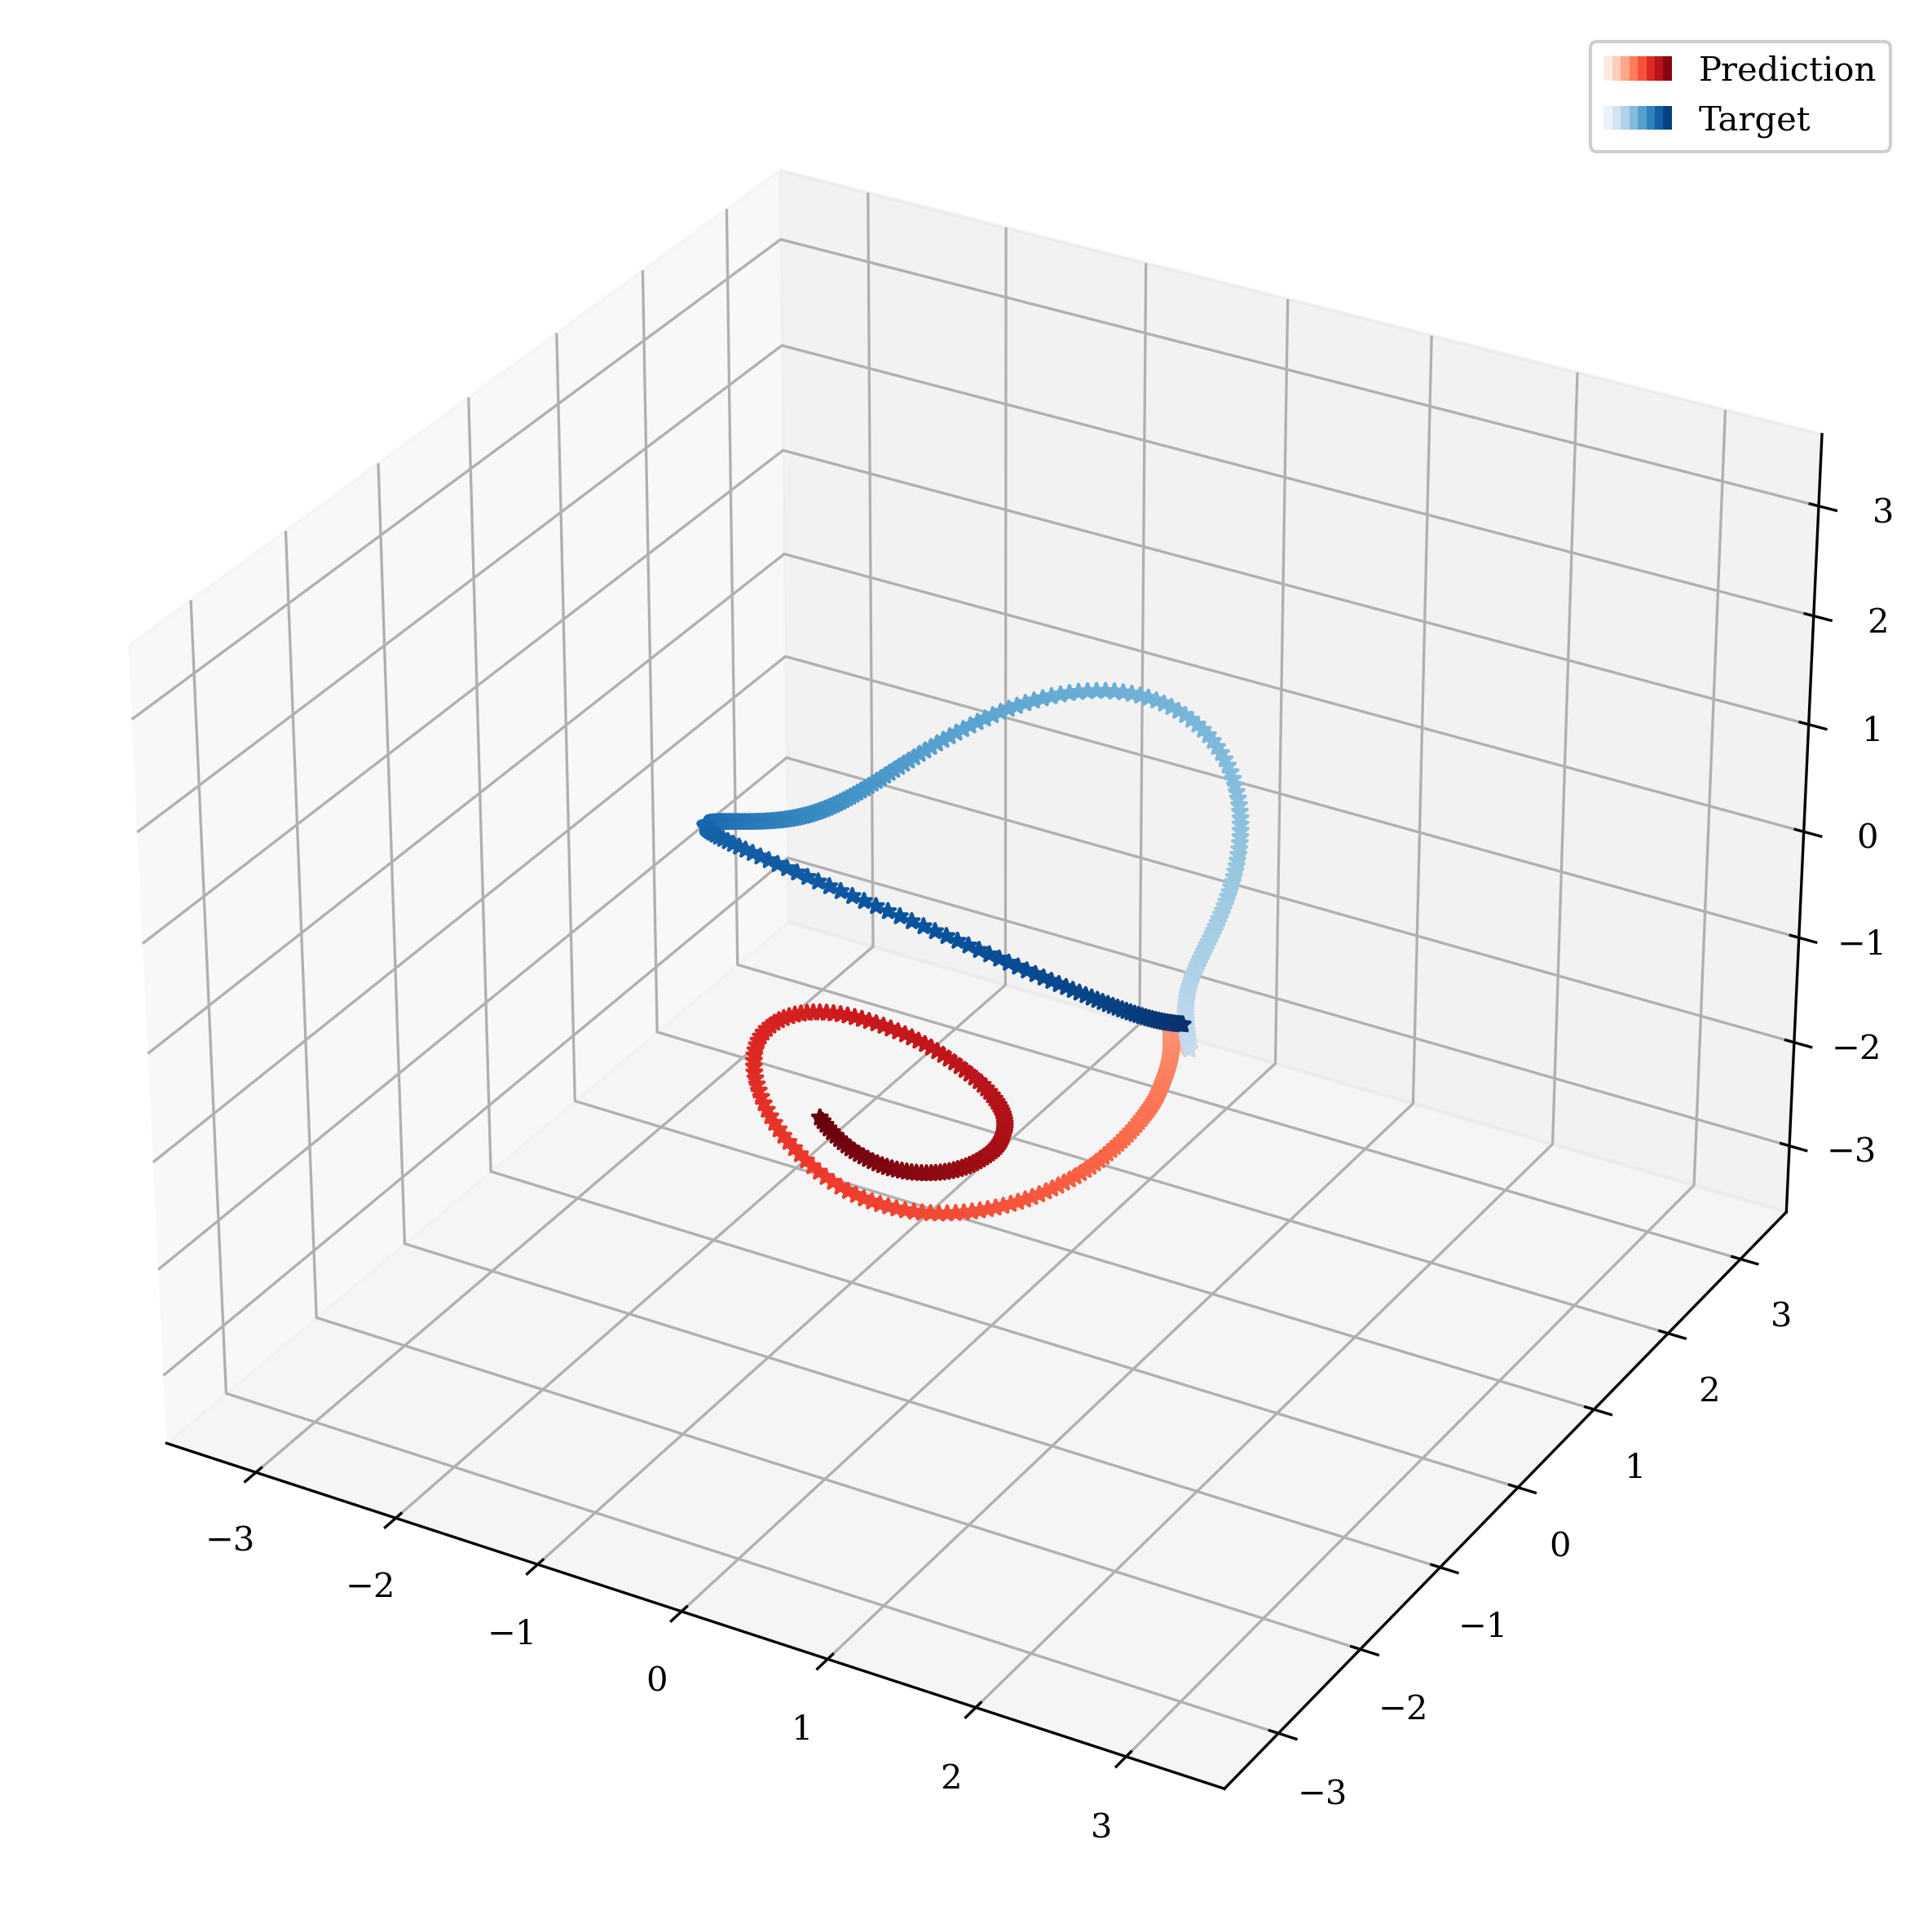

Validation prediction for epoch: 100


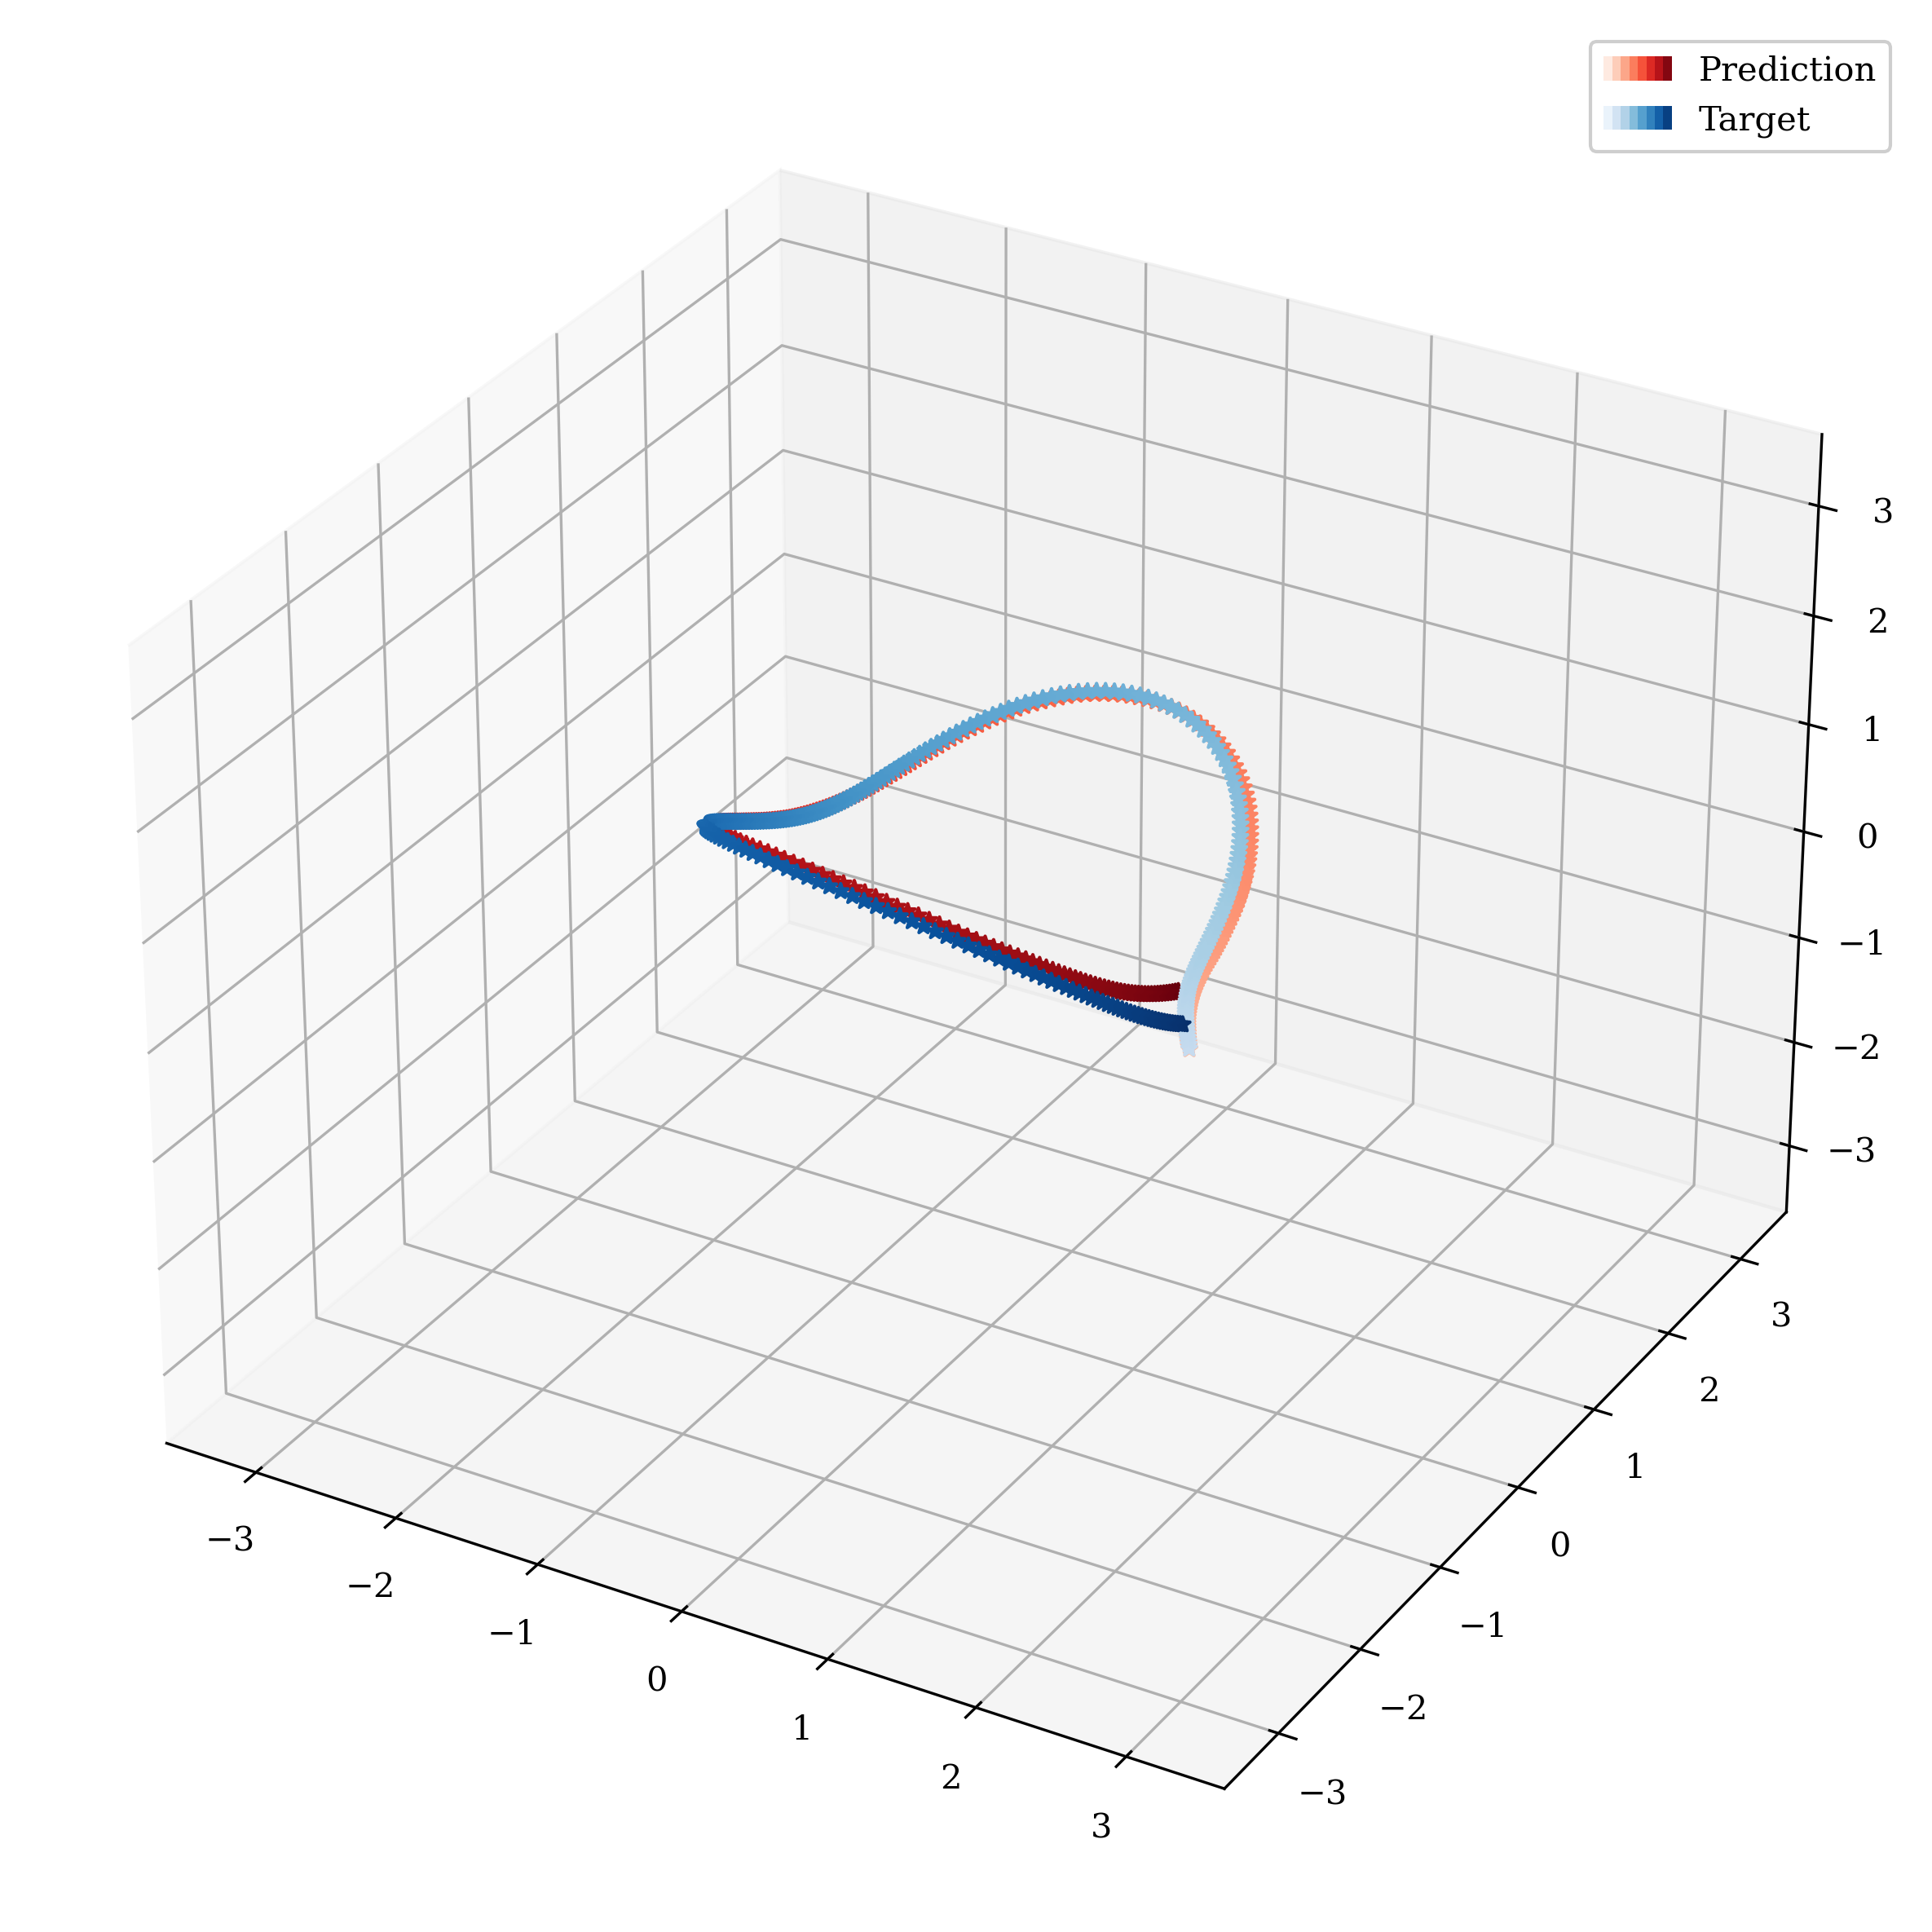

Validation prediction for epoch: 150


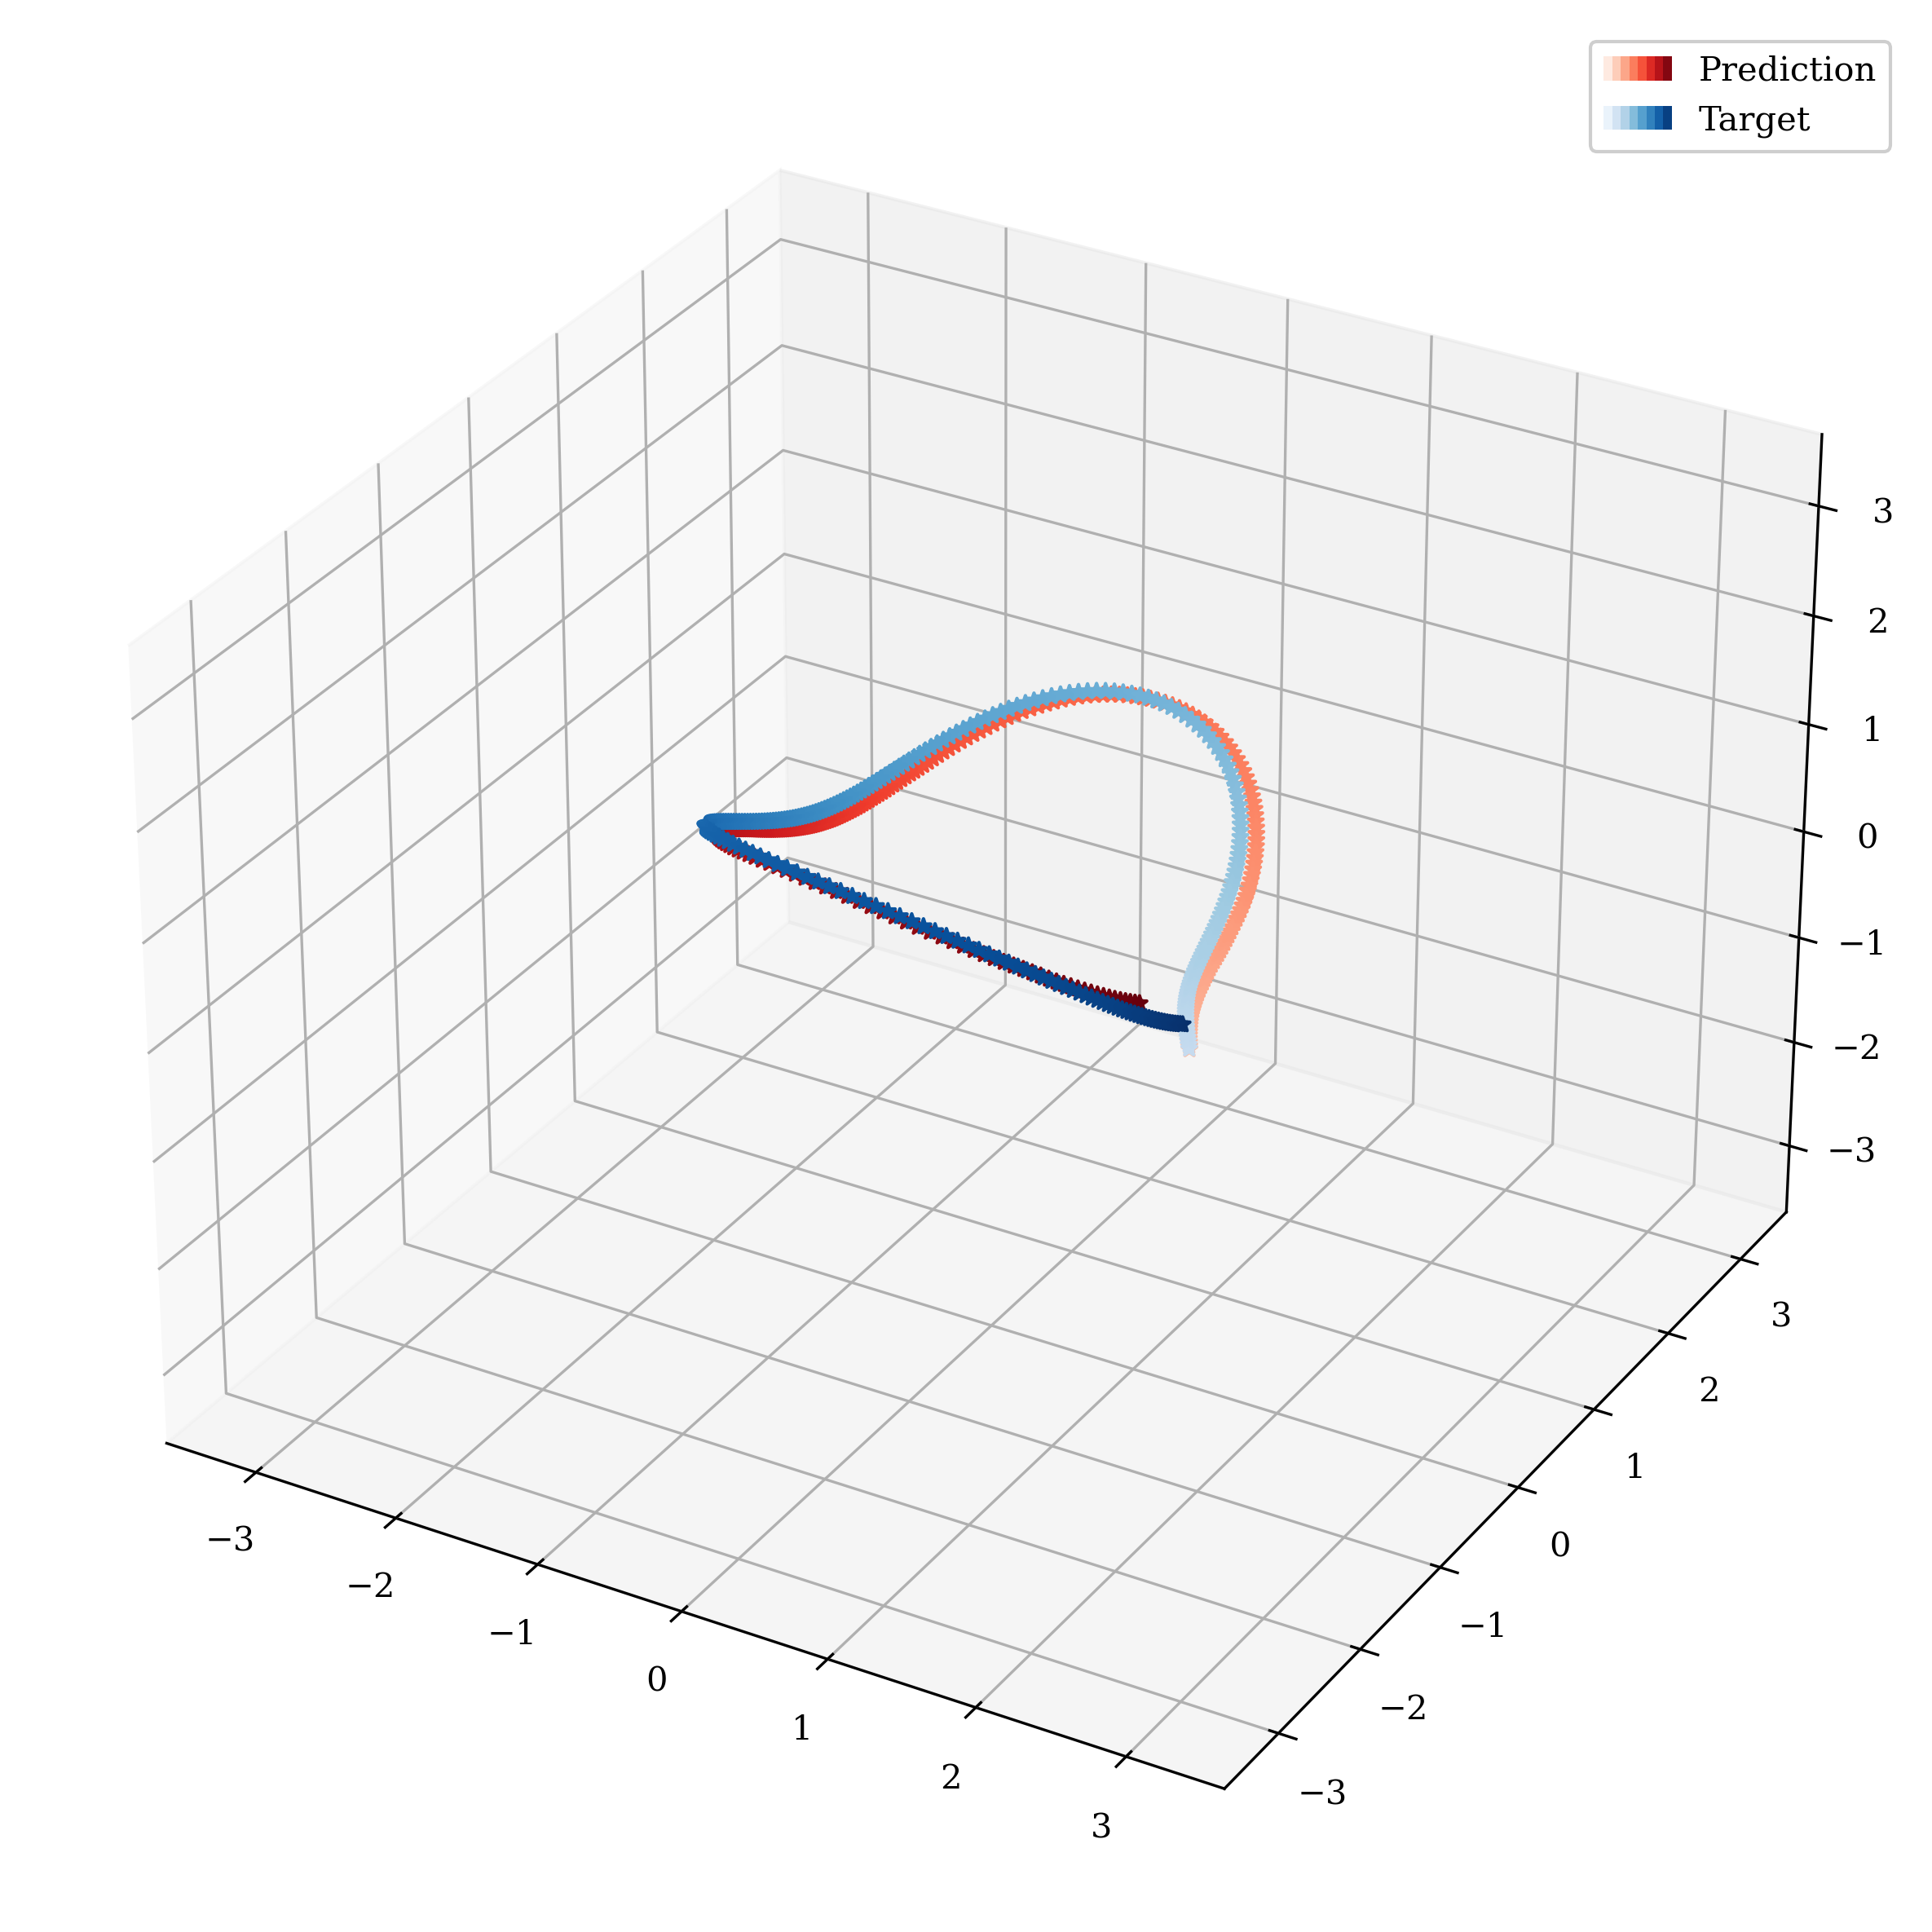

Validation prediction for epoch: 200


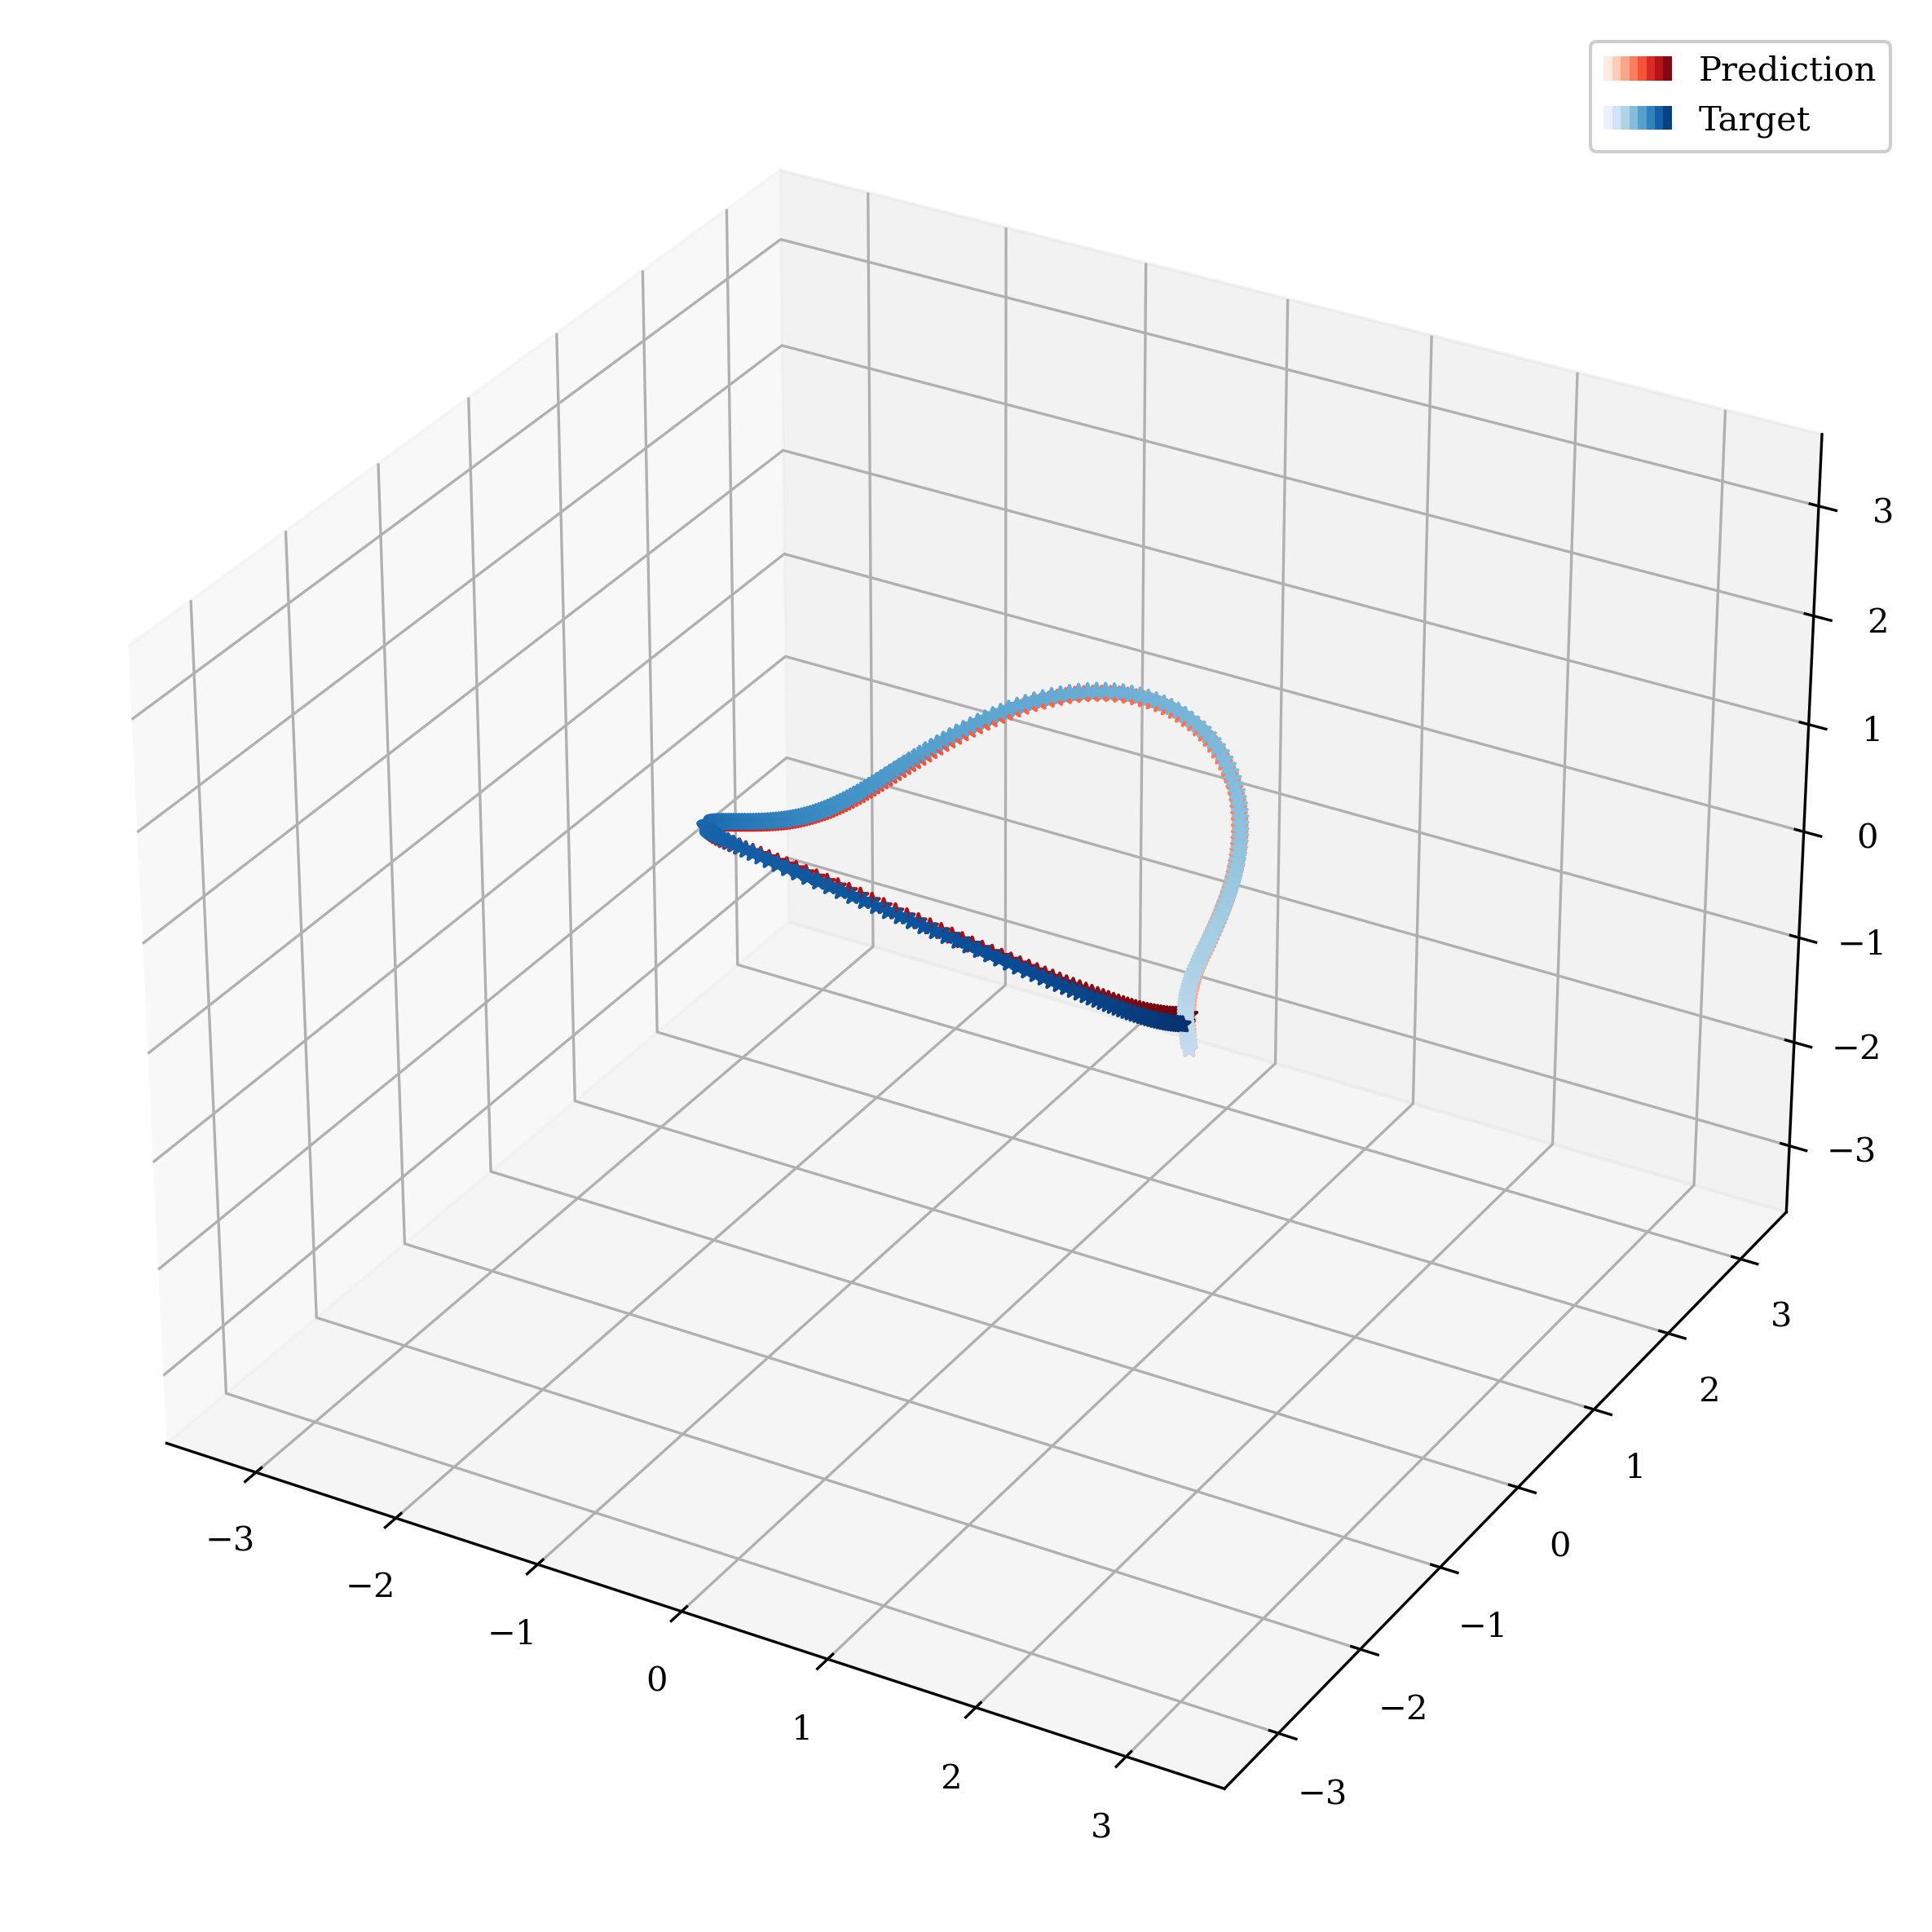

Validation prediction for epoch: 250


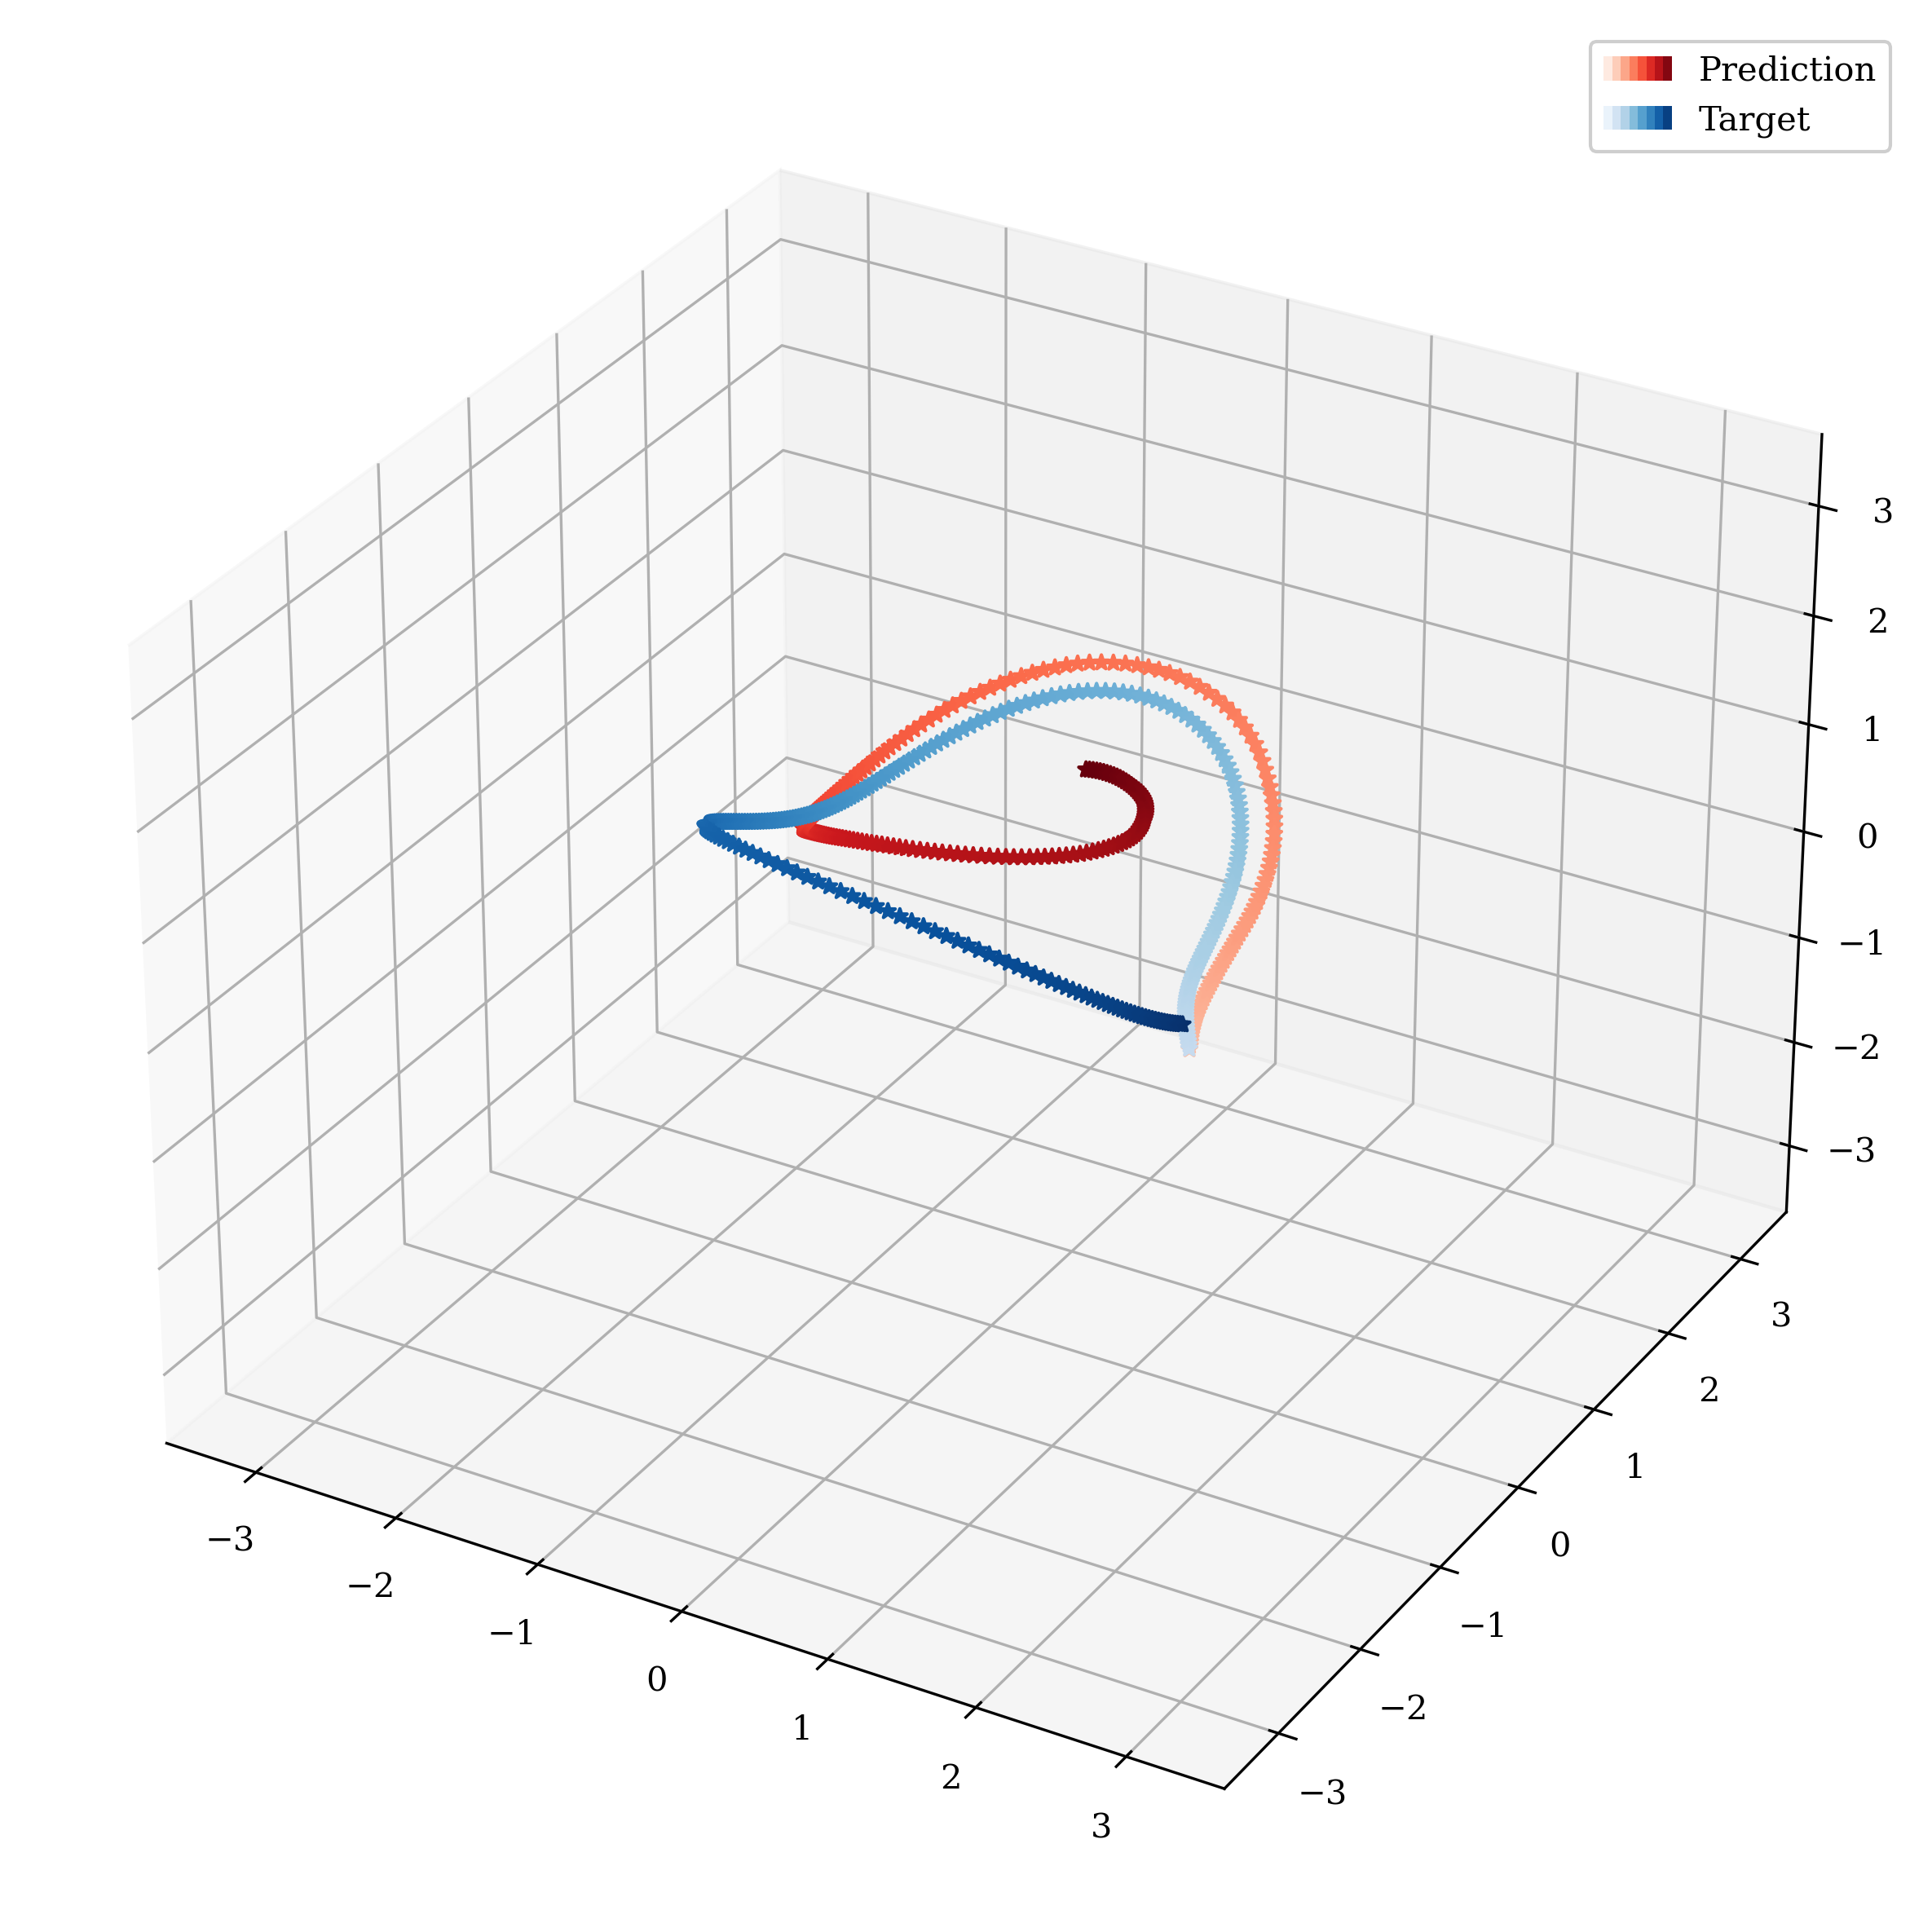

Validation prediction for epoch: 300


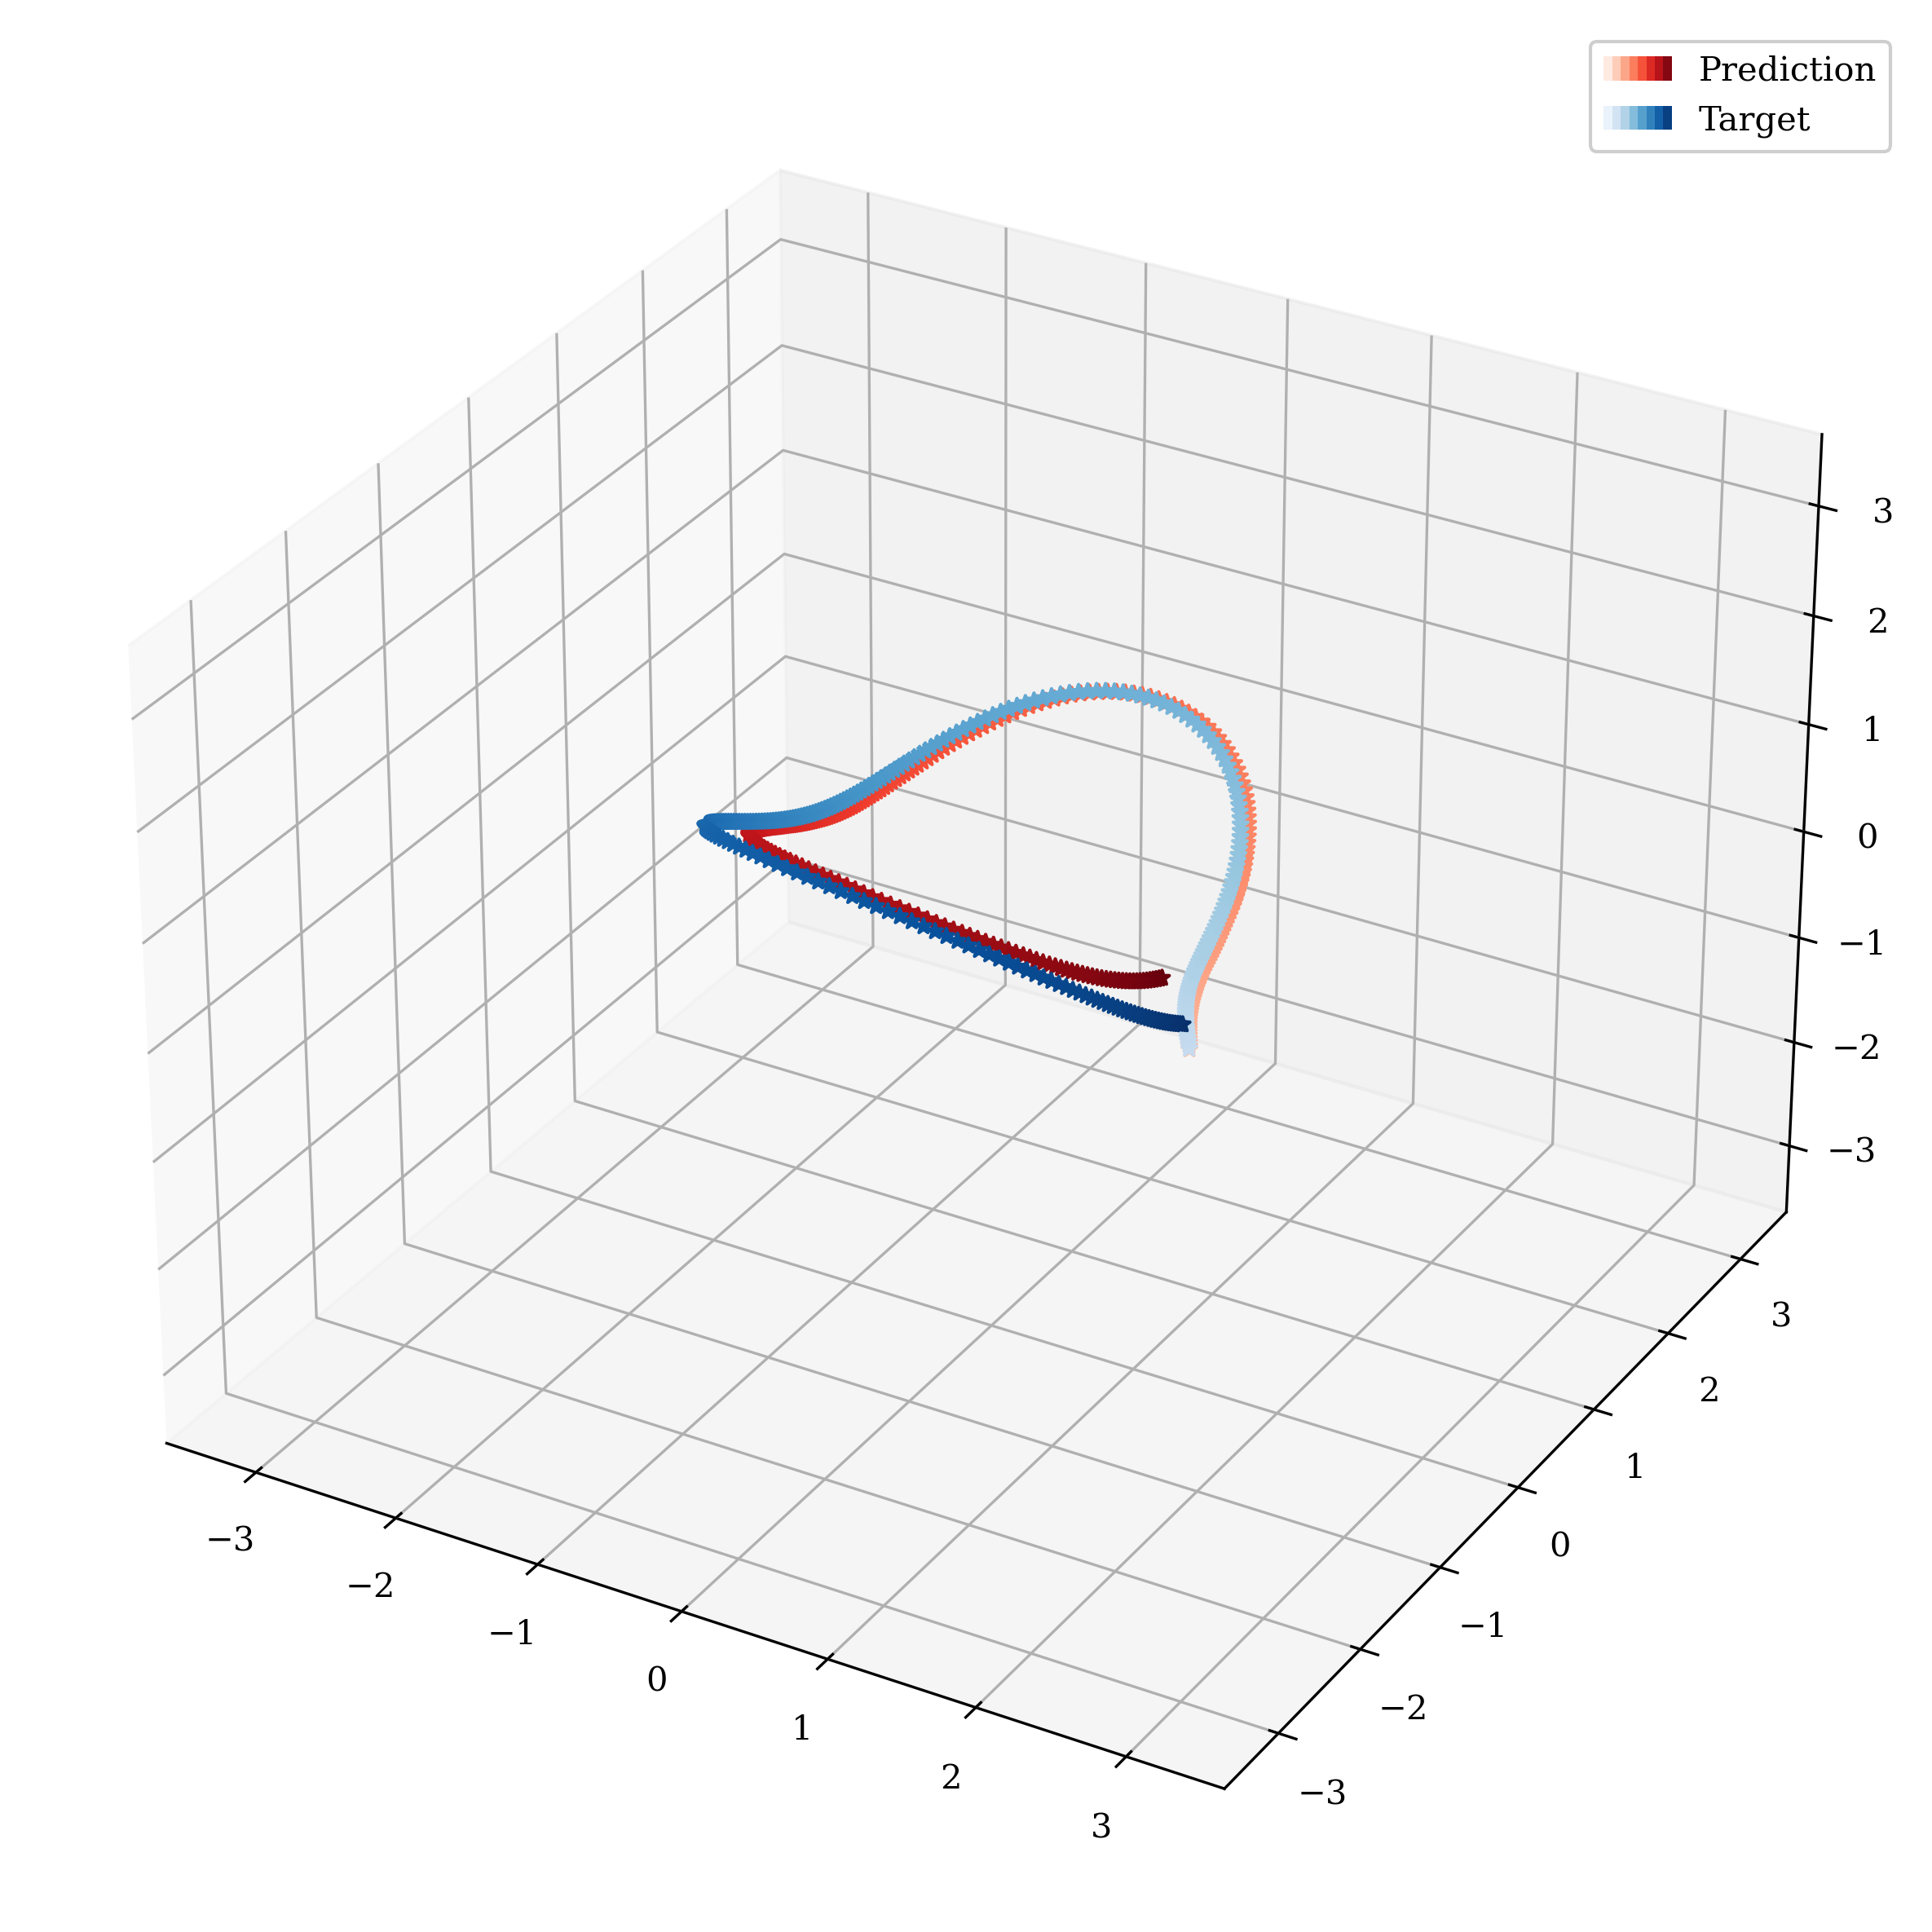

In [8]:
from IPython.display import Image, display

for epoch in [1, 50, 100, 150, 200,250,300]:
  print('Validation prediction for epoch: {:d}'.format(epoch))
  file_path = './outputs/transformer_gissinger/ntrain2048_epochs300_batch32/viz/gissingerPred0_{:d}.png'.format(epoch)
  display(Image(file_path, width=300, height=300))